In [1]:
#Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision
import albumentations as A
from itertools import chain

np.random.seed(3) #Setting random seed

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Set device to use cuda/GPU
device = torch.device("cuda")

In [2]:
#Import Dataset and impute values

from google.colab import drive
drive.mount('/content/drive')

df_train = pd.read_csv("/content/drive/MyDrive/training.csv", header = 0, sep = ',', quotechar='"')
df_test = pd.read_csv("/content/drive/MyDrive/test.csv", header = 0, sep = ',', quotechar='"')

whichfacepoints = pd.read_csv("/content/drive/MyDrive/IdLookupTable.csv", header=0, sep=',', quotechar='"')

df_train = df_train.fillna(df_train.mean()) #Replace na values with the mean of the column

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Class for Pretrained Models

class FacialKeyPoints_PreTrained(torch.utils.data.Dataset):

  def __init__(self, df_x, df_y):
    self.df_x = df_x
    self.df_y = df_y
    
    #Albumentation transformations
    self.transform = A.Compose([A.Rotate(limit = 25, p = 0.5),
                                 A.GaussNoise(),
                                 A.RandomBrightness()])

  def __len__(self):
    return len(self.df_x)

  def __getitem__(self, idx):
    row_x = self.df_x.iloc[idx]
    row_y = self.df_y.iloc[idx]
    
    y = np.float32(row_y.to_numpy())

    x = np.float32(row_x.split())/255
    x = np.reshape(x, (96,96))
    x = np.stack((x,x,x), axis=2) #Pre-trained model required 3 channel, thus stacking 3x of a single channel image
    
    x = self.transform(image = x)['image']
    x = np.reshape(x, (3,96,96))
 
    return x,y

In [4]:
# Create Training/Validation Dataset with batch sizes

def Pretrained_batches(x_train, y_train, x_val, y_val):
  dataset_train = FacialKeyPoints_PreTrained(x_train, y_train)
  dataset_val = FacialKeyPoints_PreTrained(x_val, y_val)

  dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 32, shuffle = True)
  dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size = 32, shuffle = True)

  return dataset_train, dataset_val, dataloader_train, dataloader_val

In [5]:
# Training Pre-trained Neural Network Model

def train_pretrainedmodel(dataset_train, dataset_val, dataloader_train, dataloader_val):
  model = torchvision.models.resnet18(pretrained = True) #Choosing Pre-trained model: googlenet, resnet18, vgg16
  #model.fc = torch.nn.Linear(in_features = 1024, out_features = 30) #googlenet
  model.fc = torch.nn.Linear(in_features = 512, out_features = 30) #resnet
  #model.classifier[6] = torch.nn.Linear(in_features = 4096, out_features = 30) #vgg16

  model = model.to(device)

  loss_fun = torch.nn.MSELoss() #Using Mean-Squared Error Loss since it's a regression problem
  optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.0001) #Used: Adam, RMSprop, SGD
    
  epochs = 10
  N_train = len(dataset_train)
  N_val = len(dataset_val)

  train_losses = []
  val_losses = []


  for ep in range(epochs):
    model.train()
    train_loss = 0.0
    batch_idx = 0

    for X_batch, Y_batch in dataloader_train:

      X_batch = X_batch.to(device)
      Y_batch = Y_batch.to(device)

      N_batch = X_batch.shape[0]
      outputs = model(X_batch)
      loss_oneBatch = loss_fun(outputs, Y_batch)

      model.zero_grad()
      loss_oneBatch.backward() #computing the gradient
      optimizer.step() #One interation of SGD/RMSprop/Adam/Whatever optimizer used


      train_loss += loss_oneBatch * N_batch

    model.eval()
    val_loss = 0.0
    
    for X_batch, Y_batch in dataloader_val:
      X_batch = X_batch.to(device)
      Y_batch = Y_batch.to(device)

      with torch.no_grad():
        N_batch = X_batch.shape[0]
        outputs = model(X_batch)
        loss_oneBatch = loss_fun(outputs, Y_batch)
        val_loss += loss_oneBatch * N_batch

    train_losses.append(train_loss / N_train)
    val_losses.append(val_loss / N_val)

    print('epoch: ', ep, ' train loss: ', (train_loss/ N_train), ' val loss: ', (val_loss/ N_val))


  return model, train_losses, val_losses

In [6]:
# Plotting objective function and losses

def plot_objectivefunction(train_losses, val_losses):
  plt.plot(train_losses, label = 'Training loss')
  plt.plot(val_losses, label = 'Val loss')
  plt.legend(loc = 'upper right')
  plt.title('Objective Function Value vs. Epoch')

In [7]:
# Predict values for pretrained model for test image

def predict_val(model, df_val):

  rand_num = np.random.randint(0,1783)
    
  img = df_val.iloc[rand_num, 1]
  img = np.float32(img.split( )) / 255

  x = np.reshape(img, (96,96))      
  df_val = np.stack((x,x,x), axis=2)
  df_val = np.reshape(df_val, (1,3,96,96))

  df_val = torch.tensor(df_val)
  df_val = df_val.to(device)

  pred = model(df_val)

  plt.imshow(np.reshape(img, (96,96)), cmap = 'gray')

  pred = pred.cpu().detach().numpy().flatten()
    
  #Add Facial keypoint related characteristics
  columns = ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y', 'mouth_left_corner_x', 'mouth_left_corner_y','mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y']    

  print("Facial Keypoint Locations:", pred)

  for i in range(0, 30, 2):
        if (pred[i] >= 0):
          plt.plot(pred[i], pred[i + 1], marker='o', color="red")
        else:
          plt.plot(0,0, marker='o', color="red")

Pre-trained model
epoch:  0  train loss:  tensor(1662.4081, device='cuda:0', grad_fn=<DivBackward0>)  val loss:  tensor(1138.5341, device='cuda:0')
epoch:  1  train loss:  tensor(848.7785, device='cuda:0', grad_fn=<DivBackward0>)  val loss:  tensor(592.6146, device='cuda:0')
epoch:  2  train loss:  tensor(420.5559, device='cuda:0', grad_fn=<DivBackward0>)  val loss:  tensor(281.3636, device='cuda:0')
epoch:  3  train loss:  tensor(178.5357, device='cuda:0', grad_fn=<DivBackward0>)  val loss:  tensor(98.3846, device='cuda:0')
epoch:  4  train loss:  tensor(57.9946, device='cuda:0', grad_fn=<DivBackward0>)  val loss:  tensor(23.4991, device='cuda:0')
epoch:  5  train loss:  tensor(14.9709, device='cuda:0', grad_fn=<DivBackward0>)  val loss:  tensor(14.5687, device='cuda:0')
epoch:  6  train loss:  tensor(7.0183, device='cuda:0', grad_fn=<DivBackward0>)  val loss:  tensor(9.0770, device='cuda:0')
epoch:  7  train loss:  tensor(6.4989, device='cuda:0', grad_fn=<DivBackward0>)  val loss:  t

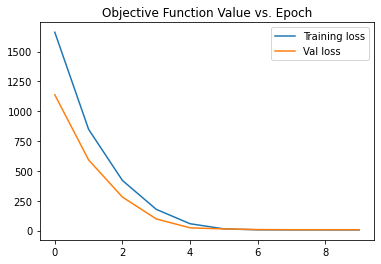

In [8]:
# Compile Main Function

X = df_train.iloc[:,30]
y = df_train.iloc[:, :30]

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

print('Pre-trained model')
dataset_train, dataset_val, dataloader_train, dataloader_val = Pretrained_batches(x_train, y_train, x_val, y_val)
model, train_losses, val_losses = train_pretrainedmodel(dataset_train, dataset_val, dataloader_train, dataloader_val)

plot_objectivefunction(train_losses, val_losses)

Facial Keypoint Locations: [66.30067  37.3825   30.455177 38.19167  58.749718 37.917477 72.97753
 37.44577  36.740887 38.10966  22.4613   38.238014 55.62336  29.317013
 79.03658  29.41448  39.181477 29.668627 15.956522 30.598959 48.509575
 63.416916 63.019756 75.91216  32.92133  76.26851  47.778652 73.05646
 48.828876 79.37095 ]


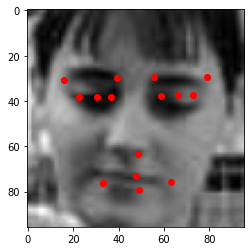

In [17]:
#Predict Facial Keypoint Values

predict_val(model, df_test)

In [10]:
# Create submission file
submission = pd.DataFrame(columns = ['Location'])

for i in range(1783):
    img = df_test.iloc[i,1]
    img = np.float32(img.split( )) / 255

    x = np.reshape(img, (96,96))
    test_x = np.stack((x,x,x))  
    test_x = np.reshape(test_x, (1,3,96,96))
    test_x = torch.tensor(test_x)
    test_x = test_x.to(device)

    pred = model(test_x)
    pred = pred.cpu().detach().numpy().flatten()

    temp_df = pd.DataFrame(data=pred, columns=['Location'])
    submission = submission.append(temp_df, ignore_index=True)

facial_features = whichfacepoints.loc[:29, ['FeatureName']]
facial_features = facial_features.values.tolist()
facial_features = list(chain.from_iterable(facial_features))

# Assigning a number to each facial feature using a dictionary
d = {};
for j in range(len(facial_features)):
  d[facial_features[j]] = j + 1

for i in range(len(whichfacepoints)):
  feat_name = whichfacepoints.loc[i,'FeatureName']
  feat_num = d[feat_name]
  img_idx = whichfacepoints.loc[i, 'ImageId']

  pred_row = ((img_idx - 1) * 30) + feat_num - 1

  whichfacepoints.loc[i,['Location']] = submission.loc[pred_row, ['Location']]

whichfacepoints = whichfacepoints.loc[:, ['RowId', 'Location']]
whichfacepoints.to_csv("C:\\Users\Abhishek Ramesh\\Google Drive\\1USF\\Spring 2021\\Math373\\HW\\Final\\submission_kaggle.csv", index = False)